                            - DỰ ĐOÁN GIÁ CLOSE CHO CTLT.csv BẰNG XGBOOST

IMPORT THƯ VIỆN

In [200]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

ĐỌC DỮ LIỆU

In [201]:
# Đọc dữ liệu
stock_ctlt = pd.read_csv('../../Dataset/CTLT.csv')

# Đổi kiểu dữ liệu Date
stock_ctlt['Date'] = pd.to_datetime(stock_ctlt['Date'])

# Set index là dữ liệu cột Date
stock_ctlt = stock_ctlt.set_index('Date')

CHUYỂN ĐỔI KIỂU DỮ LIỆU TỪ TIME SERIES SANG HỌC CÓ GIÁM SÁT

In [202]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [203]:
# n_in : 5  : Số lượng quan sát trong quá khứ
n_in = 5
# n_out: 1: số lượng dự đoán trong tương lai
n_out = 1

In [204]:
# Dự đoán cột Close
stock_ctlt_close = stock_ctlt['Close']

In [205]:
# Lấy ra giá trị của stock
values = stock_ctlt_close.values

# Đổi giá trị sang học có giám sát
data_supervised = series_to_supervised(values, n_in, n_out)

CHIA TẬP DỮ LIỆU

In [206]:
# Tạo các size cho tập dữ liệu
train_size = int(len(stock_ctlt) * 0.6)
test_size = int(len(stock_ctlt) * 0.2)
val_size = len(stock_ctlt) - train_size - test_size

In [207]:
# Lấy dữ liệu cho các tập
train_data = data_supervised[:train_size]
test_data = data_supervised[train_size:train_size+test_size]
val_data = data_supervised[train_size+test_size:]

In [208]:
X_train, y_train = train_data[:, :-n_out], train_data[:, -n_out:]
X_test, y_test = test_data[:, :-n_out], test_data[:, -n_out:]
X_val, y_val = val_data[:, :-n_out], val_data[:, -n_out:]

ĐỊNH NGHĨA MODEL

In [209]:
# Định nghĩa mô hình
    # objective: Cấu hình hàm mất mát: sử dụng hàm mất mát là mean squared error (MSE)
    # n_estimators: số lượng cây quyết định: 1000
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

In [210]:
# Huấn luyện mô hình
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds = 10)

[0]	validation_0-rmse:57.00337
[1]	validation_0-rmse:39.96657
[2]	validation_0-rmse:27.92677
[3]	validation_0-rmse:19.62622
[4]	validation_0-rmse:13.79752
[5]	validation_0-rmse:9.85168
[6]	validation_0-rmse:7.15128
[7]	validation_0-rmse:5.37774
[8]	validation_0-rmse:4.26675
[9]	validation_0-rmse:3.66281
[10]	validation_0-rmse:3.32634
[11]	validation_0-rmse:3.16614
[12]	validation_0-rmse:3.08778
[13]	validation_0-rmse:3.05716
[14]	validation_0-rmse:3.05325
[15]	validation_0-rmse:3.04292
[16]	validation_0-rmse:3.05470
[17]	validation_0-rmse:3.07118
[18]	validation_0-rmse:3.07990
[19]	validation_0-rmse:3.09083
[20]	validation_0-rmse:3.11875
[21]	validation_0-rmse:3.12517
[22]	validation_0-rmse:3.12541
[23]	validation_0-rmse:3.12964
[24]	validation_0-rmse:3.12746
[25]	validation_0-rmse:3.13559


n:\UIThoc\Nam3\Anaconda\envs\user_env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

DỰ ĐOÁN TRÊN TẬP TEST VÀ VAL

In [211]:
# Dự đoán
    # Tập test
y_pred = model.predict(X_test)

    # Tập val
y_pred_val = model.predict(X_val)

TÍNH ĐỘ LỖI CỦA MÔ HÌNH

In [212]:
# Độ lỗi mô hình trên tập test
test_mae = mean_absolute_error(y_pred, y_test)
test_mape = mean_absolute_percentage_error(y_pred, y_test)
test_mse = mean_squared_error(y_pred, y_test)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, y_test)

print(f"Testing MAE: ", test_mae)
print(f"Testing MAPE: ", test_mape)
print(f"Testing MSE: ", test_mse)
print(f"Testing RMSE: ", test_rmse)
print(f"Testing MSLE: ", test_msle)

Testing MAE:  7.144461708212426
Testing MAPE:  0.06220276822426856
Testing MSE:  91.71368341015875
Testing RMSE:  9.5767261321476
Testing MSLE:  0.005879249996770344


In [213]:
# Độ lỗi mô hình trên tập validation
val_mae = mean_absolute_error(y_pred_val, y_val)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
val_mse = mean_squared_error(y_pred_val, y_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, y_val)

print(f"Validation MAE: ",val_mae)
print(f"Validation MAPE: ", val_mape)
print(f"Validation MSE: ", val_mse)
print(f"Validation RMSE: ", val_rmse)
print(f"Validation MSLE: ", val_msle)

Validation MAE:  2.1701289093870884
Validation MAPE:  0.030224399614430037
Validation MSE:  9.259359767254397
Validation RMSE:  3.04291961235495
Validation MSLE:  0.0020618313232697054


                                    - DỰ ĐOÁN 30 NGÀY TIẾP THEO

In [214]:
# Lấy ra các ngày cuối cùng
last_date = stock_ctlt.index.max()
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [215]:
future_features = data_supervised[:, :-n_out] 

In [216]:
predicted_close_30 = []  # Danh sách dự đoán giá Close

In [217]:
for _ in range(30):
    # Dự đoán giá Close cho ngày hiện tại
    y_pred_30day = model.predict(future_features)
    predicted_close_30.append(y_pred_30day[0])  # Lấy giá trị dự đoán đầu tiên

    # # Tạo dữ liệu mới cho ngày kế tiếp
    future_features = np.roll(future_features, -1, axis=1)
    future_features[:, -1] = y_pred_30day

In [218]:
# In ra danh sách dự đoán giá Close
print(predicted_close_30)

[33.95778, 34.030247, 33.95778, 34.170387, 34.170387, 35.462902, 35.462902, 35.462902, 35.462902, 35.462902, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084, 36.37084]


In [219]:
# Tạo dataframe chứa dữ liệu 30 ngày tới
future_data = pd.DataFrame({'Date': future_dates,
                            'Close': predicted_close_30,
                            })
# Sắp xếp Date
future_data = future_data.sort_values(by='Date')

# Set index là Date
future_data.set_index('Date', inplace=True)

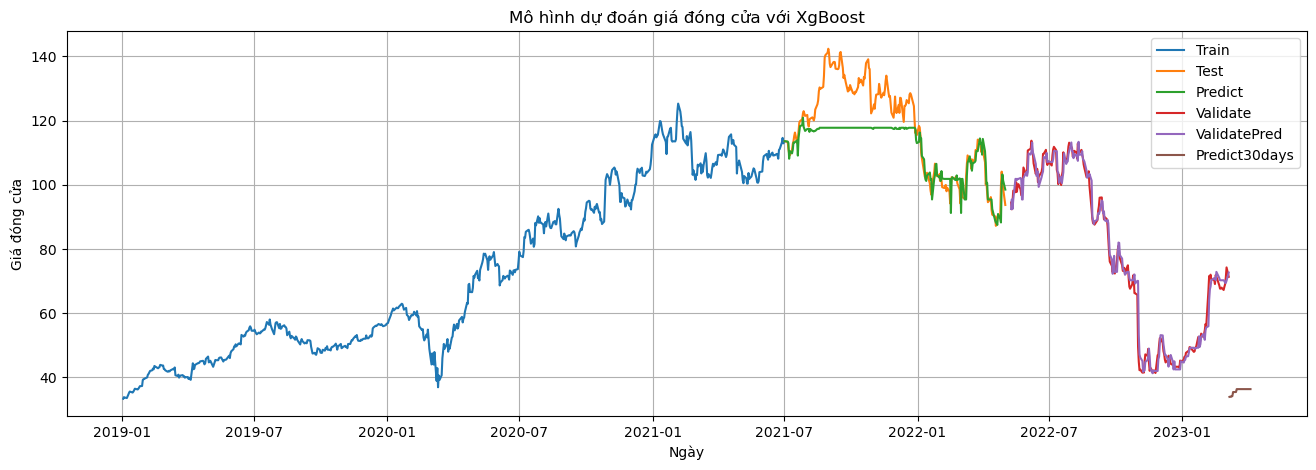

In [220]:
# Vẽ biểu đồ dự đoán và giá trị thực tế trên tập test
plt.figure(figsize=(16,5))

# Tập train
plt.plot(stock_ctlt.index[:train_size], y_train)

# Tập test
plt.plot(stock_ctlt.index[train_size:train_size+test_size], y_test)

# Dự đoán tập test
plt.plot(stock_ctlt.index[train_size:train_size+test_size], y_pred)

# Tập validate
plt.plot(stock_ctlt.index[train_size + test_size + 5: train_size + test_size + val_size], y_val)

# Dự đoán tập validate
plt.plot(stock_ctlt.index[train_size + test_size + 5: train_size + test_size + val_size], y_pred_val)

# Dự đoán cho 30 ngày tiếp theo
plt.plot(future_data.index, future_data['Close'])

plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.title('Mô hình dự đoán giá đóng cửa với XgBoost')
plt.grid()
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()